In [2]:
%load_ext autoreload
%autoreload 2

import yaml
import itertools
import joblib
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [3]:
%cd ..

/workspaces/iterative-dvc-course


# Load dataset

In [5]:
from src.stages.data_load import data_load

In [6]:
data_load("params.yaml")

Data load completed!


In [6]:
dataset = pd.read_csv(config["data"]["dataset_csv"])

In [7]:
# feature names
dataset.columns = [colname.strip(' (cm)').replace(' ', '_') for colname in dataset.columns.tolist()]

feature_names = dataset.columns.tolist()[:4]
feature_names

['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

# Features engineering

In [8]:
dataset['sepal_length_to_sepal_width'] = dataset['sepal_length'] / dataset['sepal_width']
dataset['petal_length_to_petal_width'] = dataset['petal_length'] / dataset['petal_width']

dataset = dataset[[
    'sepal_length', 'sepal_width', 'petal_length', 'petal_width',
#     'sepal_length_in_square', 'sepal_width_in_square', 'petal_length_in_square', 'petal_width_in_square',
    'sepal_length_to_sepal_width', 'petal_length_to_petal_width',
    'target'
]]

In [9]:
dataset.head()

,sepal_length,sepal_width,petal_length,petal_width,sepal_length_to_sepal_width,petal_length_to_petal_width,target
0,5.1,3.5,1.4,0.2,1.457143,7.0,0
1,4.9,3.0,1.4,0.2,1.633333,7.0,0
2,4.7,3.2,1.3,0.2,1.468750,6.5,0
3,4.6,3.1,1.5,0.2,1.483871,7.5,0
4,5.0,3.6,1.4,0.2,1.388889,7.0,0


In [10]:
# Save features
dataset.to_csv(config["preprocess"]["featured_dataset"], index=False)

# Split dataset

In [11]:
random_state = config["base"]["seed"]
test_size = config["preprocess"]["test_size"]

train_dataset, test_dataset = train_test_split(dataset, test_size=test_size, random_state=random_state)
train_dataset.shape, test_dataset.shape

((120, 7), (30, 7))

In [12]:
# Save train and test sets
train_dataset.to_csv(config["preprocess"]["output_trainset"])
test_dataset.to_csv(config["preprocess"]["output_testset"])

# Train

In [13]:
# Get X and Y
y_train = train_dataset.loc[:, 'target'].values.astype('int32')
X_train = train_dataset.drop('target', axis=1).values.astype('float32')

In [14]:
# Create an instance of Logistic Regression Classifier CV and fit the data
clf_params = config["train"]["estimator_params"]

logreg = LogisticRegression(**clf_params, random_state=random_state)
logreg.fit(X_train, y_train)

LogisticRegression(C=0.001, multi_class='multinomial', random_state=42)

In [15]:
joblib.dump(logreg, config["train"]["output_model"])

['models/model.joblib']

# Evaluate

In [16]:
from src.report.visualize import plot_confusion_matrix

In [17]:
# Get X and Y
y_test = test_dataset.loc[:, 'target'].values.astype('int32')
X_test = test_dataset.drop('target', axis=1).values.astype('float32')

In [18]:
prediction = logreg.predict(X_test)
cm = confusion_matrix(prediction, y_test)
f1 = f1_score(y_true = y_test, y_pred = prediction, average='macro')

In [19]:
# f1 score value
f1

0.9305555555555555

In [20]:
# Save metrics
metrics = {
    'f1': f1
}

with open(config["reports"]["metrics_file"], 'w') as mf:
    json.dump(
        obj=metrics,
        fp=mf,
        indent=4
    )

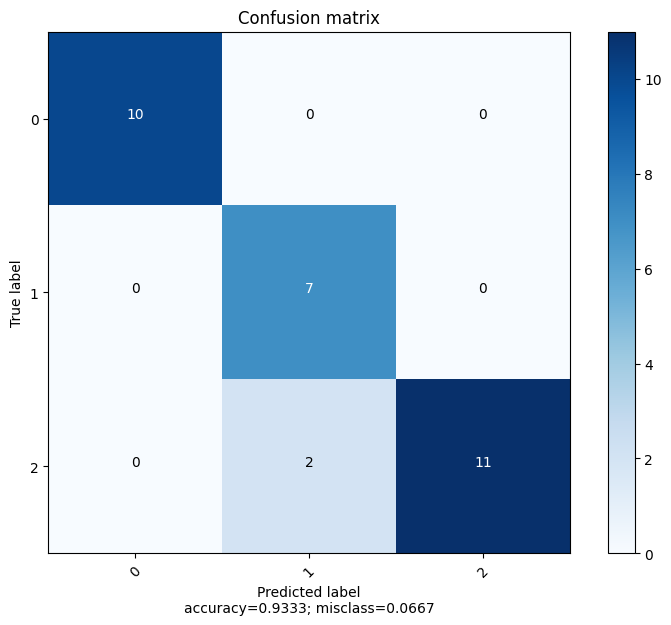

In [21]:
cm_plot = plot_confusion_matrix(cm, dataset["target"].unique(), normalize=False)

In [20]:
# Save confusion matrix image
cm_plot.savefig(config["reports"]["confusion_matrix_img"])